In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import h5py
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, concatenate
from keras.models import Model, load_model
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Go to http://nlp.stanford.edu/data/glove.6B.zip and download the GloVe Embeddings

In [2]:
BASE_DIR = ''
GLOVE_DIR = '../data'
TEXT_DATA_DIR = '../data'
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 1000 # 3519
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.7

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
# load datasets
df = pd.read_csv('../data/train.csv', sep = ",")
df_test = pd.read_csv('../data/test.csv', sep = ",")

In [5]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
print("Data has the following shape ",df.shape)

print("toxic", df.toxic.sum()/len(df))
print("severe_toxic", df.severe_toxic.sum()/len(df))
print("obscene", df.obscene.sum()/len(df))
print("threat", df.threat.sum()/len(df))
print("insult", df.insult.sum()/len(df))
print("identity_hate", df.identity_hate.sum()/len(df))

Data has the following shape  (159571, 8)
toxic 0.09584448302009764
severe_toxic 0.009995550569965721
obscene 0.052948217407925
threat 0.002995531769557125
insult 0.04936360616904074
identity_hate 0.00880485802558109


In [17]:
texts = df["comment_text"].astype('str').tolist()
labels = np.array(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']])

print('Found %s texts' % len(texts))
print('Found %s labels' % len(labels))

tests = df_test["comment_text"].astype('str').tolist()

print('Found %s tests' % len(tests))

Found 159571 texts
Found 159571 labels
Found 153164 tests


In [25]:
print(np.sum(labels, axis = 0))

[15294  1595  8449   478  7877  1405]


In [27]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = np.asarray(labels) # labels = to_categorical(np.asarray(labels)) # if multi-class classification

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

test_sequences = tokenizer.texts_to_sequences(tests)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of test_data tensor:', test_data.shape)

Found 210337 unique tokens.
Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 100)


In [28]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:num_validation_samples]
y_train = labels[:num_validation_samples]

x_val = data[num_validation_samples:]
y_val = labels[num_validation_samples:]

In [29]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(111699, 100)
(111699, 6)
(47872, 100)
(47872, 6)


In [31]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Preparing embedding matrix.


In [34]:
# Callbacks
MCP = ModelCheckpoint(filepath = "../results/ModelCheckpoint.h5py", 
                      monitor='val_loss', 
                      verbose=0, 
                      save_best_only=True, 
                      save_weights_only=False, 
                      mode='auto', 
                      period=1)

In [37]:
print('Training model.')

# train a 1D convnet with global maxpooling

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 2, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model([sequence_input], preds)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'],
              loss_weights=[1.])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          callbacks = [MCP],
          validation_data=(x_val, y_val))

Training model.
Train on 111699 samples, validate on 47872 samples
Epoch 1/30
111699/111699 [==============================] - 55s 489us/step - loss: 0.0859 - acc: 0.9727 - val_loss: 0.0701 - val_acc: 0.9771
Epoch 2/30
111699/111699 [==============================] - 54s 484us/step - loss: 0.0700 - acc: 0.9766 - val_loss: 0.0697 - val_acc: 0.9772
Epoch 3/30
111699/111699 [==============================] - 53s 476us/step - loss: 0.0676 - acc: 0.9772 - val_loss: 0.0705 - val_acc: 0.9767
Epoch 4/30
111699/111699 [==============================] - 53s 476us/step - loss: 0.0655 - acc: 0.9776 - val_loss: 0.0692 - val_acc: 0.9776
Epoch 5/30
111699/111699 [==============================] - 54s 482us/step - loss: 0.0627 - acc: 0.9782 - val_loss: 0.0696 - val_acc: 0.9774
Epoch 6/30
111699/111699 [==============================] - 54s 480us/step - loss: 0.0600 - acc: 0.9789 - val_loss: 0.0692 - val_acc: 0.9774
Epoch 7/30
111699/111699 [==============================] - 53s 478us/step - loss: 0.05

In [38]:
model.evaluate(x_val, y_val)

47872/47872 [==============================] - 7s 150us/step


[0.17499525460547274, 0.9708841509200672]

In [16]:
import pickle
with open('../results/tokenizer.pickle', 'wb') as f:
    pickle.dump([tokenizer,embedding_matrix,indices], f, -1)

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("../results/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../results/model.h5")
print("Saved model to disk")
 
# later...
 
## load json and create model
#json_file = open('../submissions/20190106/model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("../submissions/20190106/model.h5")
#print("Loaded model from disk")

Saved model to disk


# Model Validation & Analysis

In [40]:
loaded_model= load_model("../results/ModelCheckpoint.h5py")
print("Loaded model from disk")

Loaded model from disk


In [66]:
pred_train = loaded_model.predict(x_train)
pred_val = loaded_model.predict(x_val)
pred_test = loaded_model.predict(test_data)

In [67]:
print(pred_train.shape)
print(pred_val.shape)
print(pred_test.shape)

(159571, 6)
(111699, 6)
(47872, 6)
(153164, 6)


In [73]:
# Training AUC
[("AUC for training set",j,"is:", roc_auc_score(y_train[:,i],pred_train[:,i])) for i,j in enumerate(['toxic','severe_toxic','obscene','threat','insult','identity_hate'])]

[('AUC for training set', 'toxic', 'is:', 0.9503622078114888),
 ('AUC for training set', 'severe_toxic', 'is:', 0.9848775558440102),
 ('AUC for training set', 'obscene', 'is:', 0.9718958288402091),
 ('AUC for training set', 'threat', 'is:', 0.9613053487406603),
 ('AUC for training set', 'insult', 'is:', 0.9659072537251917),
 ('AUC for training set', 'identity_hate', 'is:', 0.9600908269854411)]

In [74]:
# Validation AUC
[("AUC for validation set",j,"is:", roc_auc_score(y_val[:,i],pred_val[:,i])) for i,j in enumerate(['toxic','severe_toxic','obscene','threat','insult','identity_hate'])]

[('AUC for validation set', 'toxic', 'is:', 0.9270367065284101),
 ('AUC for validation set', 'severe_toxic', 'is:', 0.9801875797090313),
 ('AUC for validation set', 'obscene', 'is:', 0.9549740283381379),
 ('AUC for validation set', 'threat', 'is:', 0.939878413387356),
 ('AUC for validation set', 'insult', 'is:', 0.94346952898666),
 ('AUC for validation set', 'identity_hate', 'is:', 0.9456452736893307)]

In [99]:
submission = np.hstack((np.asarray(df_test["id"]).reshape(-1,1),pred_test))

In [105]:
pd.DataFrame({'id':submission[:,0],
              'toxic':submission[:,1],
              'severe_toxic':submission[:,2],
              'obscene':submission[:,3],
              'threat':submission[:,4],
              'insult':submission[:,5],
              'identity_hate':submission[:,6]}).to_csv("../results/submission.csv", index = False)

In [104]:
submission.shape

(153164, 7)

In [43]:
pd.DataFrame({'Actuals' : y_train, 
              'Predictions' : pred_train}).to_csv('../results/train_results3.csv', index=False)

In [44]:
pd.DataFrame({'Actuals' : y_val, 
              'Predictions' : pred_val}).to_csv('../results/val_results3.csv', index=False)

In [45]:
pd.DataFrame({'ID' : df_test["id"], 
              'CLASS' : pred_test}).to_csv('../results/test_results3.csv', index=False)

ValueError: array length 918984 does not match index length 153164

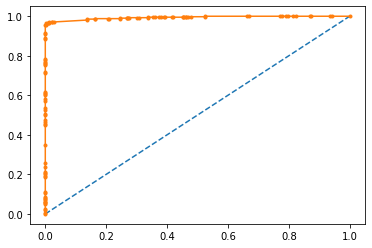

In [34]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, loaded_model.predict(x_train).reshape(-1))
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

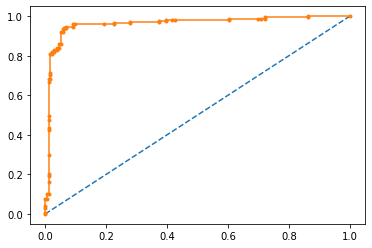

In [35]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, loaded_model.predict(x_val).reshape(-1))
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, loaded_model.predict(x_train).reshape(-1)>0.5, labels = [0,1])
cm

array([[394,   1],
       [ 18, 396]], dtype=int64)

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, loaded_model.predict(x_val).reshape(-1)>0.5, labels = [0,1])
cm

array([[164,  12],
       [ 10, 162]], dtype=int64)